In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import time

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def simulate_paths_multi(S0_vec, r, q_vec, sigma_vec, rho,
                         T, num_steps, N, seed=None):
    """Simulate N correlated GBM paths.  Return (N, num_steps+1, d)."""
    if seed is not None:
        np.random.seed(seed)

    d   = len(S0_vec)
    dt  = T / num_steps

    corr = rho * np.ones((d, d), dtype=np.float32)
    np.fill_diagonal(corr, 1.0)
    L = np.linalg.cholesky(corr)                       # (d,d) Cholesky

    S = np.zeros((N, num_steps + 1, d), dtype=np.float32)
    S[:, 0, :] = S0_vec

    drift  = (r - q_vec - 0.5 * sigma_vec**2) * dt
    vol_dt = sigma_vec * np.sqrt(dt)

    for t in range(num_steps):
        z_corr = np.random.randn(N, d).astype(np.float32) @ L.T
        S[:, t + 1, :] = S[:, t, :] * np.exp(drift + vol_dt * z_corr)

    return S


class ContinuationValueNet(nn.Module):
    """
    Neural network u^theta for continuation value
    """
    def __init__(self, d: int, width: int = None, depth: int = None,
                 negative_slope: float = 0.01, dropout: float = 0.1):
        super().__init__()
        self.d = d
        
        # Normalisation
        self.register_buffer('input_mean', torch.zeros(d + 1))
        self.register_buffer('input_std', torch.ones(d + 1))
        
        # Network
        layers = [nn.Linear(d + 1, width), nn.LeakyReLU(negative_slope)]
        
        for _ in range(depth - 2):
            layers.extend([
                nn.Linear(width, width),
                nn.LeakyReLU(negative_slope)
            ])
        
        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)
        
        # Init weights
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def set_normalization(self, mean, std):
        self.input_mean.copy_(mean)
        self.input_std.copy_(std)
    
    def forward(self, t_norm: torch.Tensor, logS: torch.Tensor) -> torch.Tensor:
        x = torch.cat([t_norm.unsqueeze(-1), logS], dim=-1)
        x = (x - self.input_mean) / (self.input_std + 1e-8)
        return self.net(x).squeeze(-1)


@torch.no_grad()
def evaluate_policy(net, soft_sigma=0.2, N_eval=20_000):
    paths = simulate_paths_multi(S0_vec, r, q_vec, sigma_vec, rho,
                                 T, num_steps, N_eval)
    paths = torch.from_numpy(paths).to(device)
    B     = paths.size(0)

    normal  = Normal(0., 1.)
    survival      = torch.ones(B, device=device)
    total_payoffs = torch.zeros(B, device=device)
    disc_vec      = torch.exp(-r * dt * torch.arange(num_steps, device=device))

    for t in range(num_steps):
        t_norm   = t / num_steps
        S_t      = paths[:, t, :]
        payoff   = torch.clamp(S_t.max(dim=-1).values - K, min=0.)
        payoff_d = payoff * disc_vec[t]

        cont = net(torch.full((B,), t_norm, device=device),
                   torch.log(S_t + 1e-12))
        x    = (payoff_d - cont) / soft_sigma
        p_t  = normal.cdf(x)

        total_payoffs += survival * p_t * payoff_d
        survival       = survival * (1 - p_t)

    S_T     = paths[:, -1, :]
    payoffT = torch.clamp(S_T.max(dim=-1).values - K, min=0.)
    total_payoffs += survival * payoffT * np.exp(-r * T)

    mean = total_payoffs.mean().item()
    se   = total_payoffs.std(unbiased=True).item() / math.sqrt(N_eval)
    return mean, se


@torch.no_grad()
def evaluate_sharp_policy(net, N_eval=20_000, seed_eval=9999):
    net.eval()

    paths = simulate_paths_multi(S0_vec, r, q_vec, sigma_vec, rho,
                                 T, num_steps, N_eval, seed=seed_eval)
    paths = torch.from_numpy(paths).to(device)
    B     = paths.size(0)

    survival      = torch.ones(B, device=device)
    total_payoffs = torch.zeros(B, device=device)
    disc_vec      = torch.exp(-r * dt * torch.arange(num_steps, device=device))

    for t in range(num_steps):
        t_norm   = t / num_steps
        S_t      = paths[:, t, :]
        payoff   = torch.clamp(S_t.max(dim=-1).values - K, min=0.)
        payoff_d = payoff * disc_vec[t]

        cont = net(torch.full((B,), t_norm, device=device),
                   torch.log(S_t + 1e-12))

        exercise = (payoff_d > cont)
        total_payoffs += survival * exercise.float() * payoff_d
        survival       = survival * (~exercise).float()

    S_T     = paths[:, -1, :]
    payoffT = torch.clamp(S_T.max(dim=-1).values - K, min=0.)
    total_payoffs += survival * payoffT * np.exp(-r * T)

    mean = total_payoffs.mean().item()
    se   = total_payoffs.std(unbiased=True).item() / math.sqrt(N_eval)
    return mean, se


class EarlyStopping:
    """
    Early stopping to stop training when improvement small
    """
    
    def __init__(self, patience=20, min_delta=1e-4, relative_threshold=1e-3, 
                 min_epochs=50, max_epochs=2000):
        self.patience = patience
        self.min_delta = min_delta
        self.relative_threshold = relative_threshold
        self.min_epochs = min_epochs
        self.max_epochs = max_epochs
        
        self.best_score = -np.inf
        self.epochs_without_improvement = 0
        self.history = []
        self.start_time = None
        
    def start_training(self):
        self.start_time = time.time()
    
    def get_elapsed_time(self):
        if self.start_time is None:
            return 0
        return time.time() - self.start_time
    
    def format_time(self, seconds):
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)
        
        if hours > 0:
            return f"{hours}h {minutes}m {seconds}s"
        elif minutes > 0:
            return f"{minutes}m {seconds}s"
        else:
            return f"{seconds}s"
            
    def should_stop(self, current_score, epoch):
        self.history.append(current_score)
        
        if epoch < self.min_epochs:
            if current_score > self.best_score:
                self.best_score = current_score
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1
            return False
        
        if epoch >= self.max_epochs:
            elapsed_time = self.get_elapsed_time()
            print(f"Maximum epochs ({self.max_epochs}) reached after {self.format_time(elapsed_time)}. Stopping training.")
            return True
        
        absolute_improvement = current_score - self.best_score
        relative_improvement = absolute_improvement / abs(self.best_score) if self.best_score != 0 else 0
        
        is_improvement = (absolute_improvement > self.min_delta and 
                         relative_improvement > self.relative_threshold)
        
        if is_improvement:
            self.best_score = current_score
            self.epochs_without_improvement = 0
            return False
        else:
            self.epochs_without_improvement += 1
            
            if self.epochs_without_improvement >= self.patience:
                elapsed_time = self.get_elapsed_time()
                print(f"Early stopping triggered after {epoch + 1} epochs ({self.format_time(elapsed_time)})")
                print(f"Best score: {self.best_score:.6f}")
                print(f"No improvement for {self.patience} epochs")
                return True
        
        return False
    
    def get_best_score(self):
        return self.best_score
    
    def get_convergence_info(self):
        """
        Return information about the convergence process
        """
        return {
            'best_score': self.best_score,
            'epochs_without_improvement': self.epochs_without_improvement,
            'total_epochs': len(self.history),
            'final_score': self.history[-1] if self.history else None,
            'training_time': self.get_elapsed_time(),
            'training_time_formatted': self.format_time(self.get_elapsed_time())
        }


def train_net(soft_sigma,
              N_train=10_000,
              batch=500,
              lr=0.003,
              seed=None,
              eval_every=10,
              width=None,
              depth=None,
              dropout=0.1,
              curriculum=True,
              # Early stopping parameters
              patience=25,
              min_delta=1e-4,
              relative_threshold=1e-3,
              min_epochs=50,
              max_epochs=2000):
    """
    Train continuation‑value network
    """
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    net = ContinuationValueNet(d, width=width, depth=depth, dropout=dropout).to(device)
    optimiser = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimiser, mode='max', patience=15, factor=0.5, verbose=True, min_lr=1e-6
    )
    
    # Init early stopping
    early_stopping = EarlyStopping(
        patience=patience,
        min_delta=min_delta,
        relative_threshold=relative_threshold,
        min_epochs=min_epochs,
        max_epochs=max_epochs
    )
    
    normal = Normal(0., 1.)
    disc_vec = torch.exp(-r * dt * torch.arange(num_steps, device=device))

    steps_per_epoch = N_train // batch
    train_hist, eval_hist = [], []
    
    # Input normalization
    print("Setting up input normalization...")
    log_S0 = np.log(S0_vec[0])
    input_mean = torch.tensor([0.5] + [log_S0] * d, device=device)
    input_std = torch.tensor([0.3] + [0.3] * d, device=device)
    net.set_normalization(input_mean, input_std)
    
    if curriculum:
        def get_soft_sigma(ep):
            # Gradually decrease from 2*soft_sigma to soft_sigma over first 200 epochs
            if ep < 200:
                return soft_sigma * (2 - ep / 200)
            return soft_sigma
    else:
        get_soft_sigma = lambda ep: soft_sigma

    print(f"Starting training with early stopping (patience={patience}, min_epochs={min_epochs})")
    print(f"Will stop when improvement < {min_delta:.2e} absolute or < {relative_threshold:.2e} relative")
    
    early_stopping.start_training()
    
    ep = 0
    while True:
        current_soft_sigma = get_soft_sigma(ep)
        epoch_reward_sum = 0.0
        net.train()

        for _ in range(steps_per_epoch):
            S_b = torch.from_numpy(
                simulate_paths_multi(S0_vec, r, q_vec, sigma_vec, rho,
                                     T, num_steps, batch)
            ).to(device)
            B = S_b.size(0)

            logS = torch.log(S_b[:, :num_steps, :] + 1e-12)
            logS_f = logS.reshape(-1, d)
            t_norm = torch.arange(num_steps, device=device).repeat(B) / num_steps
            cont = net(t_norm, logS_f).view(B, num_steps)

            payoff_now = torch.clamp(S_b[:, :num_steps, :].max(dim=-1).values - K, 0.)
            payoff_disc = payoff_now * disc_vec.unsqueeze(0)

            survival = torch.ones(B, device=device)
            total_payoffs = torch.zeros(B, device=device)

            for t in range(num_steps):
                x_t = (payoff_disc[:, t] - cont[:, t]) / current_soft_sigma
                p_t = normal.cdf(x_t)

                total_payoffs += survival * p_t * payoff_disc[:, t]
                survival = survival * (1 - p_t)

            payoff_T = torch.clamp(S_b[:, -1, :].max(dim=-1).values - K, 0.)
            total_payoffs += survival * payoff_T * np.exp(-r * T)

            optimiser.zero_grad()
            loss = -total_payoffs.mean()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimiser.step()
            epoch_reward_sum += total_payoffs.mean().item()

        avg_reward = epoch_reward_sum / steps_per_epoch
        train_hist.append(avg_reward)
        
        # Evaluation and early stopping check
        if (ep + 1) % eval_every == 0:
            net.eval()
            eval_mean, _ = evaluate_policy(net, current_soft_sigma, N_eval=10_000)
            eval_hist.append((ep + 1, eval_mean))
            
            # Update learning rate scheduler
            scheduler.step(eval_mean)
            
            # Calculate elapsed time
            elapsed_time = early_stopping.get_elapsed_time()
            time_per_epoch = elapsed_time / (ep + 1)
            
            print(f"Epoch {ep + 1:4d} | "
                  f"train‑avg = {avg_reward:8.4f} | "
                  f"soft‑eval = {eval_mean:8.4f} | "
                  f"best = {early_stopping.get_best_score():8.4f} | "
                  f"no_improve = {early_stopping.epochs_without_improvement:2d} | "
                  f"time = {early_stopping.format_time(elapsed_time)} | "
                  f"epoch_time = {time_per_epoch:.1f}s | "
                  f"soft_sigma = {current_soft_sigma:.3f} | "
                  f"lr = {optimiser.param_groups[0]['lr']:.2e}")
            
            # Check for early stopping
            if early_stopping.should_stop(eval_mean, ep + 1):
                break
        else:
            if early_stopping.should_stop(avg_reward, ep + 1):
                break
        
        ep += 1
    
    convergence_info = early_stopping.get_convergence_info()
    print(f"\nTraining completed after {ep + 1} epochs")
    print(f"Total training time: {convergence_info['training_time_formatted']}")
    print(f"Average time per epoch: {convergence_info['training_time'] / (ep + 1):.1f}s")
    print(f"Best evaluation score: {convergence_info['best_score']:.6f}")
    print(f"Final score: {convergence_info['final_score']:.6f}")
    
    return net, train_hist, eval_hist, convergence_info['training_time_formatted']

def average_time_in_seconds(times):
    """
    Helper function for checking training time
    """
    seconds = [float(t.strip('s')) for t in times]   
    avg = sum(seconds) / len(seconds)  
    return round(avg, 1)

# Option Parameters

In [ ]:
S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = np.full(d, 0.2, dtype=np.float32)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps

# d = 2

In [30]:
d = 2
seed = 42

prices = []
times = []
n_trials = 8

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Epoch   10 | train‑avg =  13.6977 | soft‑eval =  13.7763 | best =  13.6522 | no_improve =  0 | time = 0s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   20 | train‑avg =  13.6729 | soft‑eval =  13.8019 | best =  13.8992 | no_improve =  0 | time = 0s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   30 | train‑avg =  13.6974 | soft‑eval =  13.8090 | best =  14.0186 | no_improve =  7 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   40 | train‑avg =  13.7443 | soft‑eval =  13.9459 | best =  14.0599 | no_improve =  4 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   50 | train‑avg =  13.6540 | soft‑eval =  13.7534 | best =  14.1562 | no_improve =  3 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   60 | train

In [31]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 13.887 (0.004)
Max Price = 13.892
Times = ['10s', '31s', '11s', '16s', '10s', '15s', '10s', '17s']


In [56]:
times = ['10s', '31s', '11s', '16s', '10s', '15s', '10s', '17s']
print(f"Average training time = {average_time_in_seconds(times)}")

Average training time = 15.0


# d = 5

In [51]:
d = 5
seed = 42

prices = []
times = []
n_trials = 8

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Epoch   10 | train‑avg =  25.3125 | soft‑eval =  25.0067 | best =  24.6955 | no_improve =  1 | time = 0s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   20 | train‑avg =  25.6957 | soft‑eval =  25.8577 | best =  25.9975 | no_improve =  4 | time = 0s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   30 | train‑avg =  25.7148 | soft‑eval =  25.4968 | best =  26.0327 | no_improve =  7 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   40 | train‑avg =  25.5437 | soft‑eval =  26.2114 | best =  26.2684 | no_improve =  4 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   50 | train‑avg =  25.8283 | soft‑eval =  25.8653 | best =  26.2684 | no_improve = 14 | time = 2s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   60 | train

In [52]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 26.092 (0.012)
Max Price = 26.111
Times = ['21s', '20s', '21s', '26s', '13s', '16s', '27s', '12s']


In [55]:
times = ['21s', '20s', '21s', '26s', '13s', '16s', '27s', '12s']
print(f"Average training time = {average_time_in_seconds(times)}")

Average training time = 19.5


# d = 10

Training with early stopping...
Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Epoch   10 | train‑avg =  35.9539 | soft‑eval =  35.9936 | best =  35.7872 | no_improve =  1 | time = 0s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   20 | train‑avg =  37.7155 | soft‑eval =  37.8466 | best =  37.7485 | no_improve =  1 | time = 1s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   30 | train‑avg =  37.7644 | soft‑eval =  37.6760 | best =  38.2192 | no_improve =  0 | time = 2s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   40 | train‑avg =  37.8519 | soft‑eval =  37.9669 | best =  38.2192 | no_improve = 10 | time = 3s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   50 | train‑avg =  37.7776 | soft‑eval =  37.9302 | best =  38.2192 | no_improve = 20 | time = 4s | epoch_time = 0.1s | soft_sigma = 2.000 | 

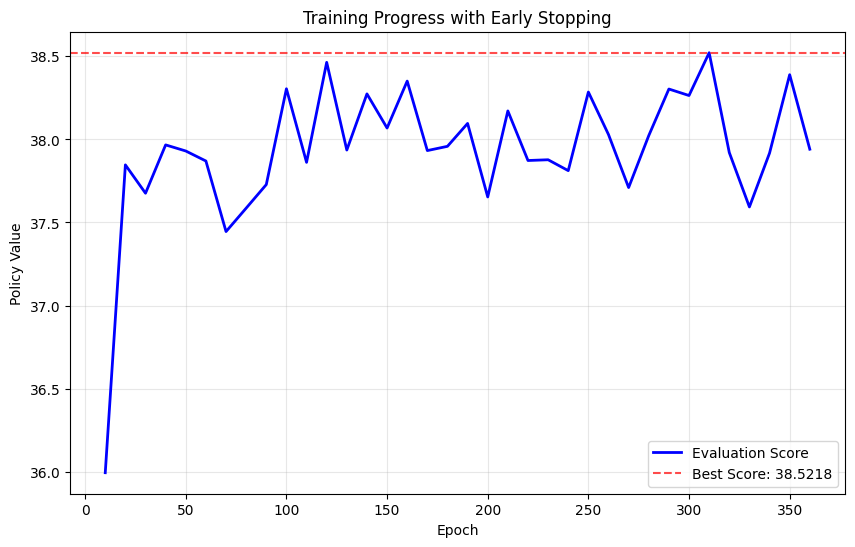

In [7]:
d = 10
seed = 42

net, train_hist, eval_hist = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
)

print("\nEvaluating final policy...")
sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=1_000_000)
print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

if len(eval_hist) > 0:
    epochs, scores = zip(*eval_hist)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, scores, 'b-', linewidth=2, label='Evaluation Score')
    plt.axhline(y=max(scores), color='r', linestyle='--', alpha=0.7, label=f'Best Score: {max(scores):.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Policy Value')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [27]:
d = 10
seed = 42

prices = []
times = []
n_trials = 8

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    # Early stopping parameters
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Epoch   10 | train‑avg =  35.9539 | soft‑eval =  35.9936 | best =  35.7872 | no_improve =  1 | time = 0s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   20 | train‑avg =  37.7155 | soft‑eval =  37.8466 | best =  37.7485 | no_improve =  1 | time = 1s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   30 | train‑avg =  37.7644 | soft‑eval =  37.6760 | best =  38.2192 | no_improve =  0 | time = 2s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   40 | train‑avg =  37.8519 | soft‑eval =  37.9669 | best =  38.2192 | no_improve = 10 | time = 3s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   50 | train‑avg =  37.7776 | soft‑eval =  37.9302 | best =  38.2192 | no_improve = 20 | time = 4s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   60 | train

In [29]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 38.194 (0.030)
Max Price = 38.242
Times = ['31s', '45s', '36s', '36s', '41s', '57s', '48s', '26s']


In [54]:
times = ['31s', '45s', '36s', '36s', '41s', '57s', '48s', '26s']
print(f"Average training time = {average_time_in_seconds(times)}")

Average training time = 40.0
